In [1]:
library(tidyverse)

-- Attaching packages --------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
models_df <- read_csv('../../pure2/Metabolic Syndrome/data/models_df.csv')
daily_info <- read_csv('../../pure2/Metabolic Syndrome/data/daily_info.csv')
pure_processed <- read_csv('../../pure2/Metabolic Syndrome/data/pureData_processed2.csv')
pa_info <- read_csv('../../pure2/Metabolic Syndrome/data/pa_info.csv')


-- Column specification --------------------------------------------------------------------------------
cols(
  .default = col_double(),
  sex = col_character(),
  location_type = col_character(),
  education = col_character(),
  smokes = col_character(),
  drinks = col_character(),
  elevated_bp = col_logical(),
  elevated_wcm = col_logical(),
  elevated_triglycerids_mg_d_l = col_logical(),
  elevated_glucose_mg_d_l = col_logical(),
  low_hdl_mg_d_l = col_logical(),
  met_s = col_logical(),
  gr_per_day_dairy = col_logical(),
  gr_per_day_eggs = col_logical(),
  gr_per_day_fruits_vegtables = col_logical(),
  gr_per_day_legumes = col_logical(),
  gr_per_day_white_meat = col_logical()
)
i<U+00A0>Use `spec()` for the full column specifications.



-- Column specification --------------------------------------------------------------------------------
cols(
  id = col_double(),
  pure_name = col_character(),
  pure_portion = col_double(),
  weight_portion_gr = col_double(),
  type = col

# Association between carbonated drinks and MetS

In [10]:
daily_info %>%
    filter(type == "beverages") %>%
    distinct(pure_name)

pure_name
<chr>
natural_juice
commercial_juice
soft_drink
soft_light_drink
tea
oat_drink
iced_tea
beer
wine


In [11]:
diets_carb_drinks <- 
    daily_info %>%
        filter(name == "energy") %>%
        mutate(type = 
               case_when(pure_name %in% c("soft_drink", "soft_light_drink") ~ "carbonated_drink", 
                        TRUE ~ type)) %>%
        filter(type %in% c('legumes', 'legume_soup', 
                           'fish', 'chicken', 'pork', 
                           'beef', 'dairy', 
                           'carbonated_drink'), 
               !str_detect(pure_name, 'skimmed')) %>% 
        group_by(id, pure_name, type) %>% 
        summarise(pure_portion = max(pure_portion)) %>% 
        mutate(type = case_when(type %in% c('legumes', 'legume_soup') ~ 'legumes', 
                                type %in% c('fish', 'chicken', 'pork') ~ 'white_meat', 
                                TRUE ~ type)) %>% 
        group_by(id, type) %>% 
        summarise(portions_by_type = sum(pure_portion)) %>%
        ungroup()

`summarise()` has grouped output by 'id', 'pure_name'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'id'. You can override using the `.groups` argument.



In [12]:
diets_carb_drinks %>%
    filter(type == "carbonated_drink") %>%
    .$portions_by_type %>%
    quantile(probs = c(1/3, 2/3))

33.33333% 66.66667% 
     0.00      0.14

In [13]:
dcd <- diets_carb_drinks %>%
    filter(type == "carbonated_drink") %>%
    mutate(carbonated_drink = 
               case_when(portions_by_type == 0 ~ "low", 
                        portions_by_type <= 0.14 ~ "normal", 
                        portions_by_type > 0.14 ~ "high")) %>%
    select(id, carbonated_drink) %>%
    inner_join(diets_carb_drinks, by = "id") %>%
    filter(type != "carbonated_drink") 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



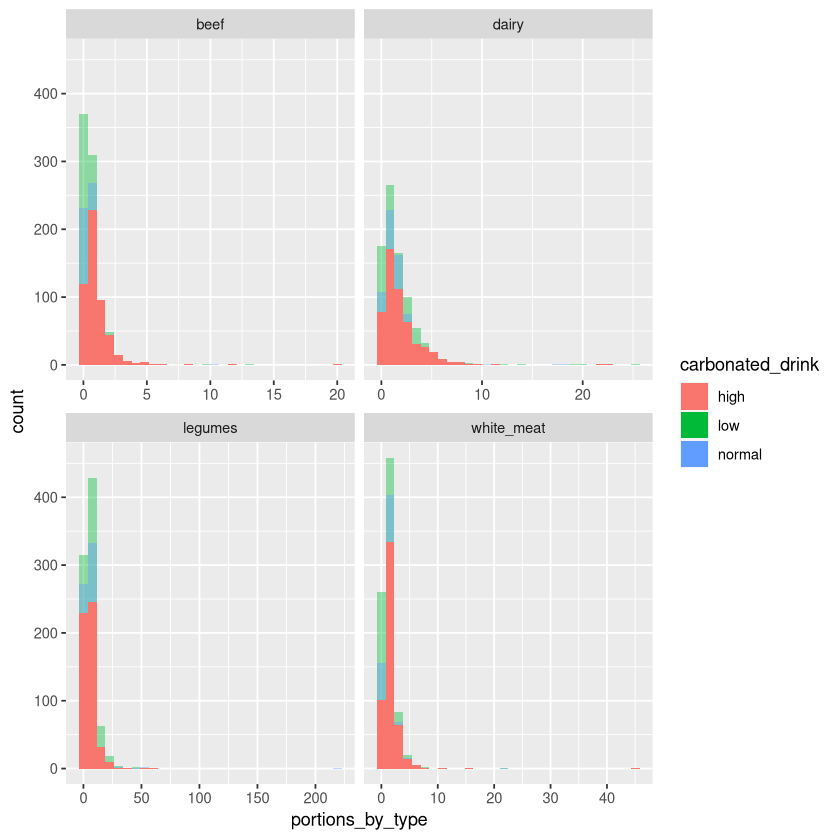

In [14]:
ggplot(dcd, aes(portions_by_type, fill = carbonated_drink)) +
    geom_histogram(data = dcd %>% filter(carbonated_drink == "low"),
                  alpha = 0.4) +
    geom_histogram(data = dcd %>% filter(carbonated_drink == "normal"),
                  alpha = 0.4) +
    geom_histogram(data = dcd %>% filter(carbonated_drink == "high")) +
    facet_wrap(~type, scales = "free_x")

`summarise()` has grouped output by 'carbonated_drink'. You can override using the `.groups` argument.



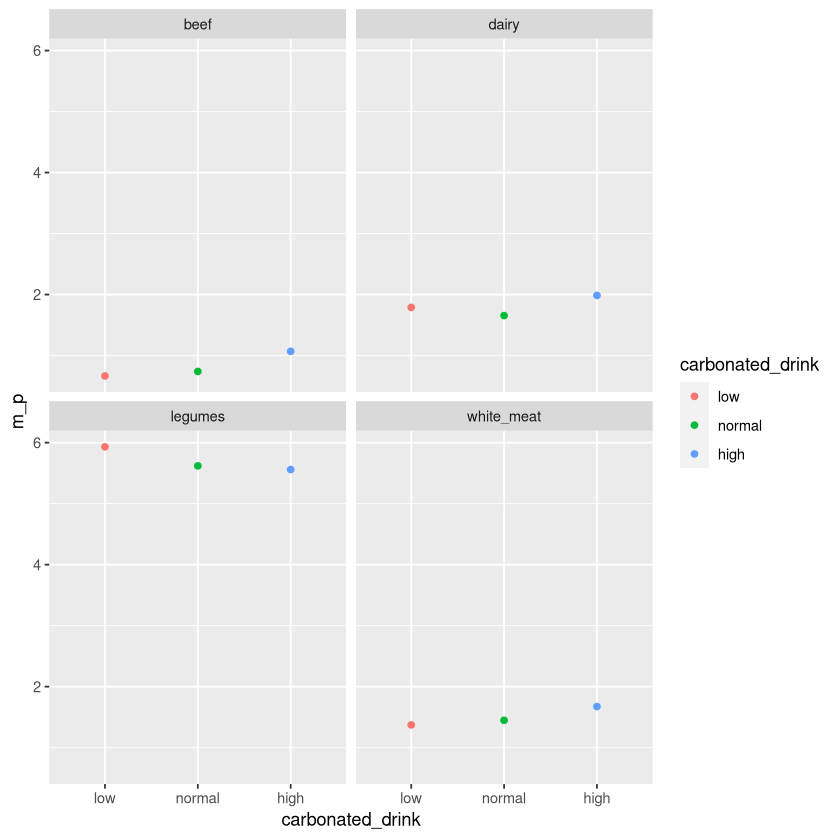

In [15]:
dcd %>%
    group_by(carbonated_drink, type) %>%
    summarise(m_p = mean(portions_by_type), 
              sd_p = sd(portions_by_type)) %>%
    mutate(carbonated_drink = as.factor(carbonated_drink),
          carbonated_drink = 
           fct_relevel(carbonated_drink, c("low", "normal"))) %>%
    ggplot(aes(x = carbonated_drink, 
               y = m_p, 
               color = carbonated_drink)) +
    geom_point() +
    facet_wrap(~type)

In [16]:
low_legumes <- dcd %>% 
        filter(type == "legumes", carbonated_drink == "low") %>%
        pull(portions_by_type)

normal_legumes <- dcd %>% 
        filter(type == "legumes", carbonated_drink == "normal") %>%
        pull(portions_by_type)

high_legumes <- dcd %>% 
        filter(type == "legumes", carbonated_drink == "high") %>%
        pull(portions_by_type)

wilcox.test(low_legumes, normal_legumes)
wilcox.test(low_legumes, high_legumes)
wilcox.test(normal_legumes, high_legumes)


	Wilcoxon rank sum test with continuity correction

data:  low_legumes and normal_legumes
W = 286602, p-value = 0.01968
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  low_legumes and high_legumes
W = 230946, p-value = 0.04055
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  normal_legumes and high_legumes
W = 168096, p-value = 0.9654
alternative hypothesis: true location shift is not equal to 0


# Comparing models with and without carbonated drinks:

In [17]:
portions_cat  <- seq(0, 1, 0.5)

whtr_info <-
    pure_processed %>% 
        select(id, whtr)

hd_diag_info <-
    pure_processed %>% 
        select(id, d_diagnosed, h_diagnosed)

drinks_info <- 
    dcd %>% 
        select(id, carbonated_drink) %>%
        distinct(id, carbonated_drink)

energy_info <- 
    daily_info %>% 
        filter(name == 'energy') %>% 
        group_by(id) %>% 
        summarise(diet_energy = sum(amount_per_day))

metS_cols <- c('id', 'sex', 'age', 'income', 'location_type', 
               'education', 'waist', 'bmi', 'whr', 
               'smokes', 'drinks', 
               'elevated_bp', 'elevated_wcm', 
               'elevated_triglycerids_mg_d_l', 'elevated_glucose_mg_d_l',
               'low_hdl_mg_d_l', 'n_conditions', 
               'met_s')

mets_conds <- models_df %>% select(all_of(metS_cols))

portions_info <- 
    dcd %>%
        select(-carbonated_drink) %>%
        pivot_wider(names_from = type, values_from = portions_by_type)

portions_and_mets_df <- 
    dcd %>%
        mutate(type = paste(type, '_cat', sep = ''), 
               portions_cat = cut(portions_by_type, 
                                   labels = 
                                      c('[0, 0.5]', ']0.5, 1]', '1+'),
                                   breaks = c(portions_cat, Inf), 
                                   include.lowest = TRUE)) %>%
        select(-carbonated_drink, -portions_by_type) %>%
        pivot_wider(names_from = type, values_from = portions_cat) %>%
        inner_join(drinks_info, by = "id") %>%
        inner_join(energy_info, by = "id") %>%
        inner_join(portions_info, by = "id") %>%
        inner_join(hd_diag_info, by = "id") %>%
        inner_join(whtr_info, by = "id") %>%
        inner_join(mets_conds, by = "id") %>%
        inner_join(pa_info, by = "id")
    

In [18]:
mod_metS_drinks <- glm(met_s ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                carbonated_drink +
                beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
                portions_and_mets_df, family=binomial)


In [19]:
mod_diab_drinks <- glm(d_diagnosed ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                carbonated_drink +
                beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
                portions_and_mets_df, family=binomial)

In [20]:
mod_ht_drinks <- glm(h_diagnosed ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                carbonated_drink +
                beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
                portions_and_mets_df, family=binomial)

In [49]:
mod_metS <- glm(met_s ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
                portions_and_mets_df, family=binomial)

In [46]:
mod_diab <- glm(d_diagnosed ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
                portions_and_mets_df, family=binomial)

In [56]:
mod_ht <- glm(h_diagnosed ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
                portions_and_mets_df, family=binomial)

#### MetS

In [50]:
summary(mod_metS_drinks)


Call:
glm(formula = met_s ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    carbonated_drink + beef_cat + dairy_cat + white_meat_cat + 
    legumes_cat, family = binomial, data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5883  -0.9021  -0.5118   1.0332   2.3013  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.129e+01  9.876e-01 -11.431  < 2e-16 ***
sexWoman                2.151e-01  1.598e-01   1.346  0.17830    
age                     3.863e-02  5.715e-03   6.760 1.38e-11 ***
bmi                     1.573e-01  1.354e-02  11.619  < 2e-16 ***
whr                     6.162e+00  9.257e-01   6.656 2.81e-11 ***
location_typeUrban     -8.609e-02  1.093e-01  -0.788  0.43070    
educationLow           -6.224e-02  1.780e-01  -0.350  0.72664    
educationMiddle         1.068e-01  1.706e-01   0.626  0.53104    
income   

In [57]:
summary(mod_metS)


Call:
glm(formula = met_s ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    beef_cat + dairy_cat + white_meat_cat + legumes_cat, family = binomial, 
    data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6005  -0.9088  -0.5128   1.0273   2.2574  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.106e+01  9.762e-01 -11.334  < 2e-16 ***
sexWoman                2.216e-01  1.592e-01   1.392  0.16385    
age                     4.007e-02  5.655e-03   7.086 1.38e-12 ***
bmi                     1.549e-01  1.347e-02  11.500  < 2e-16 ***
whr                     6.020e+00  9.239e-01   6.515 7.25e-11 ***
location_typeUrban     -7.340e-02  1.089e-01  -0.674  0.50042    
educationLow           -7.457e-02  1.778e-01  -0.420  0.67483    
educationMiddle         1.029e-01  1.704e-01   0.604  0.54597    
income                 -1.01

#### D2M

In [52]:
summary(mod_diab_drinks)


Call:
glm(formula = d_diagnosed ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    carbonated_drink + beef_cat + dairy_cat + white_meat_cat + 
    legumes_cat, family = binomial, data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3308  -0.4971  -0.3757  -0.2726   2.7302  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -8.837e+00  1.381e+00  -6.399 1.57e-10 ***
sexWoman                3.519e-01  2.486e-01   1.416  0.15687    
age                     5.040e-02  8.992e-03   5.605 2.08e-08 ***
bmi                     4.695e-02  1.741e-02   2.696  0.00702 ** 
whr                     3.275e+00  1.267e+00   2.584  0.00975 ** 
location_typeUrban      4.638e-02  1.685e-01   0.275  0.78310    
educationLow           -7.769e-02  2.886e-01  -0.269  0.78776    
educationMiddle         4.954e-02  2.798e-01   0.177  0.85945    
inc

In [58]:
summary(mod_diab)


Call:
glm(formula = d_diagnosed ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    beef_cat + dairy_cat + white_meat_cat + legumes_cat, family = binomial, 
    data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2045  -0.5065  -0.3783  -0.2787   2.6944  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -8.579e+00  1.361e+00  -6.304 2.90e-10 ***
sexWoman                3.667e-01  2.472e-01   1.483   0.1380    
age                     5.282e-02  8.888e-03   5.942 2.81e-09 ***
bmi                     4.341e-02  1.719e-02   2.526   0.0115 *  
whr                     3.122e+00  1.253e+00   2.491   0.0127 *  
location_typeUrban      5.694e-02  1.678e-01   0.339   0.7344    
educationLow           -1.046e-01  2.880e-01  -0.363   0.7165    
educationMiddle         4.484e-02  2.789e-01   0.161   0.8723    
income                

#### HT

In [59]:
summary(mod_ht_drinks)


Call:
glm(formula = h_diagnosed ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    carbonated_drink + beef_cat + dairy_cat + white_meat_cat + 
    legumes_cat, family = binomial, data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7604  -0.7710  -0.4876   0.8215   2.8390  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -7.906e+00  1.019e+00  -7.760 8.49e-15 ***
sexWoman               -8.584e-01  1.726e-01  -4.975 6.54e-07 ***
age                     8.151e-02  6.629e-03  12.296  < 2e-16 ***
bmi                     8.689e-02  1.309e-02   6.637 3.19e-11 ***
whr                     9.712e-01  9.577e-01   1.014   0.3105    
location_typeUrban      2.441e-01  1.216e-01   2.007   0.0447 *  
educationLow            1.865e-01  2.081e-01   0.896   0.3702    
educationMiddle         3.044e-01  2.001e-01   1.521   0.1282    
inc

In [60]:
summary(mod_ht)


Call:
glm(formula = h_diagnosed ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    beef_cat + dairy_cat + white_meat_cat + legumes_cat, family = binomial, 
    data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6975  -0.7642  -0.4939   0.8323   2.7732  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -7.928e+00  1.011e+00  -7.841 4.46e-15 ***
sexWoman               -8.705e-01  1.719e-01  -5.063 4.12e-07 ***
age                     8.124e-02  6.553e-03  12.396  < 2e-16 ***
bmi                     8.603e-02  1.300e-02   6.616 3.69e-11 ***
whr                     9.344e-01  9.561e-01   0.977   0.3284    
location_typeUrban      2.487e-01  1.213e-01   2.049   0.0404 *  
educationLow            1.889e-01  2.074e-01   0.911   0.3624    
educationMiddle         3.133e-01  1.997e-01   1.569   0.1166    
income                

# Interactions:

In [26]:
library(interactions)

In [27]:
mod_metS_edu <- 
    glm(met_s ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                carbonated_drink +
                beef_cat + dairy_cat + white_meat_cat + 
                legumes * education, 
                portions_and_mets_df, family=binomial)

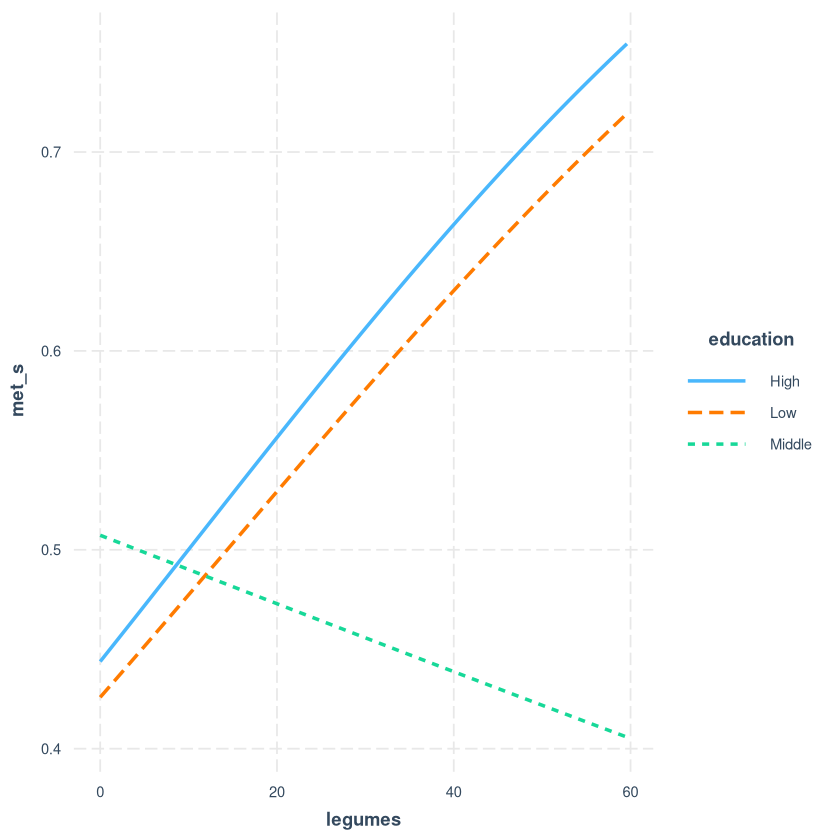

In [28]:
interact_plot(mod_metS_edu, pred = legumes, modx = education)

In [29]:
mod_metS_inc <- 
    glm(met_s ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                carbonated_drink +
                beef_cat + dairy_cat + white_meat_cat + 
                legumes * income, 
                portions_and_mets_df, family=binomial)

Warning message:
"-84.5983395732901 is outside the observed range of income"


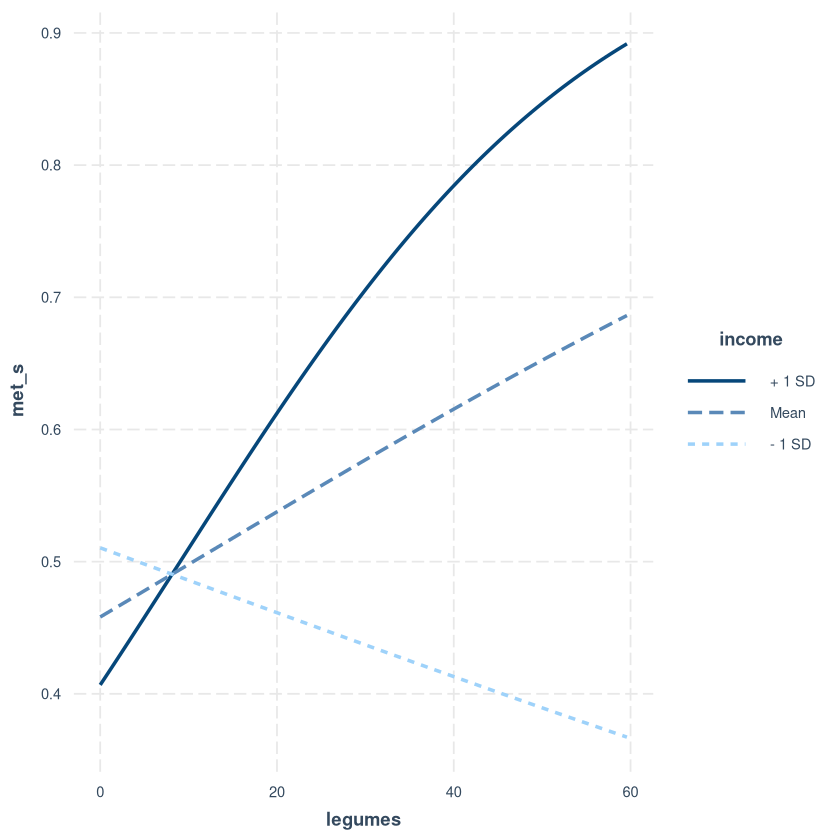

In [30]:
interact_plot(mod_metS_inc, pred = legumes, modx = income)

In [31]:
mod_metS_type <- 
    glm(met_s ~ sex + age + 
                bmi + whr +
                location_type + education + income +
                smokes + drinks + 
                diet_energy + total_pa +
                carbonated_drink +
                beef_cat + dairy_cat + white_meat_cat + 
                legumes * location_type, 
                portions_and_mets_df, family=binomial)

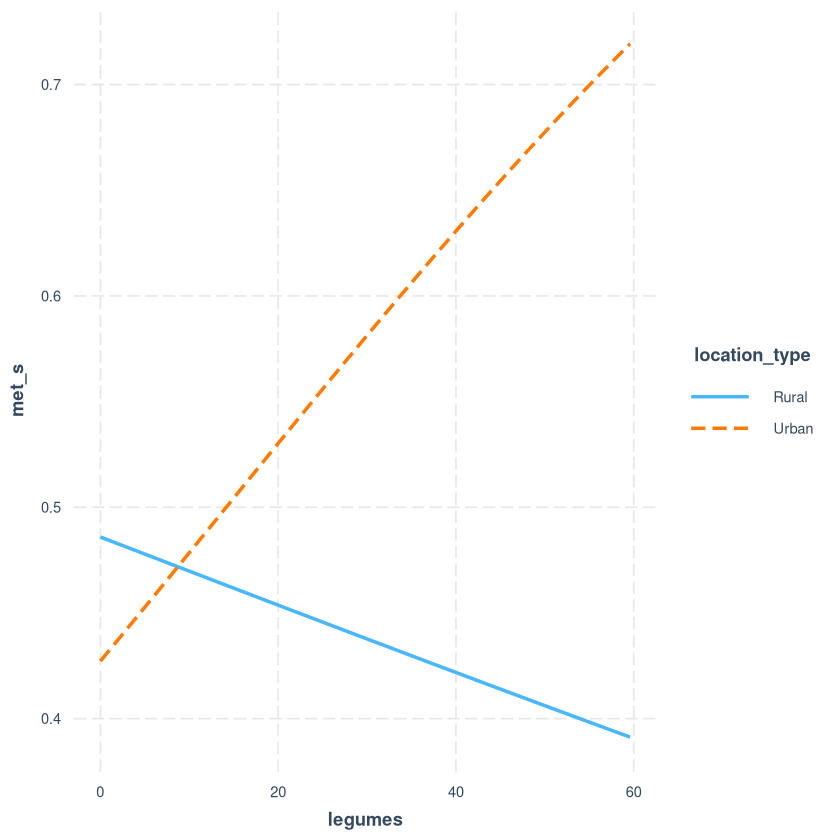

In [32]:
interact_plot(mod_metS_type, pred = legumes, modx = location_type)

In [33]:
glm(met_s ~ sex + age + 
            bmi + whr +
            location_type + education + income +
            smokes + drinks + 
            diet_energy + total_pa +
            carbonated_drink +
            beef_cat + dairy_cat + white_meat_cat + 
            legumes_cat * income, 
            portions_and_mets_df, family=binomial) %>%
    summary()


Call:
glm(formula = met_s ~ sex + age + bmi + whr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    carbonated_drink + beef_cat + dairy_cat + white_meat_cat + 
    legumes_cat * income, family = binomial, data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5858  -0.9024  -0.5108   1.0332   2.3017  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.126e+01  1.055e+00 -10.667  < 2e-16 ***
sexWoman                    2.118e-01  1.601e-01   1.323   0.1859    
age                         3.873e-02  5.722e-03   6.769  1.3e-11 ***
bmi                         1.571e-01  1.354e-02  11.601  < 2e-16 ***
whr                         6.164e+00  9.261e-01   6.657  2.8e-11 ***
location_typeUrban         -8.439e-02  1.093e-01  -0.772   0.4403    
educationLow               -6.472e-02  1.780e-01  -0.363   0.7162    
educationMiddle             1.033e

# Lupin Percentage:

In [34]:
legumes_data <- 
    daily_info %>%
        filter(name == "energy") %>%
        mutate(type = 
               case_when(pure_name %in% c("soft_drink", "soft_light_drink") ~ "carbonated_drink", 
                        TRUE ~ type)) %>%
        filter(type %in% c('legumes', 'legume_soup', 
                           'fish', 'chicken', 'pork', 
                           'beef', 'dairy', 
                           'carbonated_drink'), 
               !str_detect(pure_name, 'skimmed')) %>% 
        group_by(id, pure_name, type) %>% 
        summarise(pure_portion = max(pure_portion)) %>% 
        mutate(type = case_when(type %in% c('legumes', 'legume_soup') ~ 'legumes', 
                                type %in% c('fish', 'chicken', 'pork') ~ 'white_meat', 
                                TRUE ~ type)) %>%
        filter(type == "legumes")

`summarise()` has grouped output by 'id', 'pure_name'. You can override using the `.groups` argument.



In [35]:
legumes_data %>% 
    ungroup() %>%
    mutate(total = sum(pure_portion)) %>%
    group_by(pure_name) %>%
    summarise(total = max(total), 
              percent = 100 * round(sum(pure_portion) / total, 2)) %>%
    arrange(-percent) %>%
    select(pure_name, percent)

pure_name,percent
<chr>,<dbl>
fava_bean,41
lupin,21
peas,18
green_beans,5
bean_stew,4
legume_soup,4
lentil_stew,4
minestrone_lentil,2


### Waist to height ratio and Waist to hip ratio:

`geom_smooth()` using formula 'y ~ x'



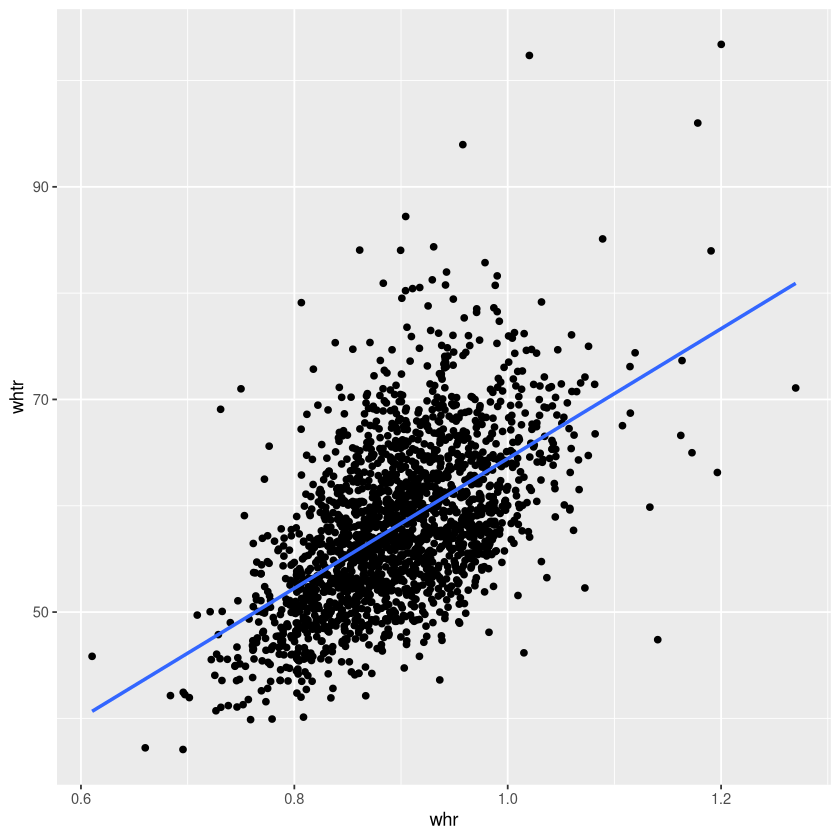

In [36]:
pure_processed %>%
    select(whr, whtr) %>%
    ggplot(aes(x = whr, y = whtr)) +
    geom_point() + 
    geom_smooth(method = "lm", se = FALSE)

In [74]:
corr_data <- pure_processed %>% mutate(whr_100 = whr * 100)
lm(whr_100 ~ whtr + sex, corr_data) %>%
    summary()

cor(pure_processed$whr, pure_processed$whtr)


Call:
lm(formula = whr_100 ~ whtr + sex, data = corr_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.847  -2.650  -0.028   2.698  33.217 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  60.5917     0.7875   76.94   <2e-16 ***
whtr          0.6041     0.0136   44.42   <2e-16 ***
sexWoman     -8.3829     0.2369  -35.39   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.682 on 1994 degrees of freedom
Multiple R-squared:  0.5822,	Adjusted R-squared:  0.5817 
F-statistic:  1389 on 2 and 1994 DF,  p-value: < 2.2e-16


[1] 0.565377

# Models with waist-to-height ratio:

In [62]:
glm(met_s ~ sex + age + 
        bmi + whtr +
        location_type + education + income +
        smokes + drinks + 
        diet_energy + total_pa +
        beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
        portions_and_mets_df, family=binomial) %>%
    summary()


Call:
glm(formula = met_s ~ sex + age + bmi + whtr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    beef_cat + dairy_cat + white_meat_cat + legumes_cat, family = binomial, 
    data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6091  -0.9133  -0.5394   1.0474   2.1714  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -7.389e+00  6.894e-01 -10.718  < 2e-16 ***
sexWoman               -2.649e-01  1.397e-01  -1.896  0.05802 .  
age                     3.800e-02  5.785e-03   6.570 5.04e-11 ***
bmi                     9.364e-02  2.239e-02   4.182 2.89e-05 ***
whtr                    6.747e-02  1.392e-02   4.847 1.25e-06 ***
location_typeUrban     -2.899e-02  1.090e-01  -0.266  0.79030    
educationLow           -9.593e-02  1.781e-01  -0.539  0.59015    
educationMiddle         6.956e-02  1.698e-01   0.410  0.68200    
income                 -9.9

In [63]:
glm(d_diagnosed ~ sex + age + 
        bmi + whtr +
        location_type + education + income +
        smokes + drinks + 
        diet_energy + total_pa +
        beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
        portions_and_mets_df, family=binomial) %>%
    summary()


Call:
glm(formula = d_diagnosed ~ sex + age + bmi + whtr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    beef_cat + dairy_cat + white_meat_cat + legumes_cat, family = binomial, 
    data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9887  -0.5051  -0.3781  -0.2834   2.6435  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -6.495e+00  9.668e-01  -6.719 1.84e-11 ***
sexWoman                1.035e-01  2.251e-01   0.460   0.6456    
age                     5.242e-02  9.063e-03   5.784 7.30e-09 ***
bmi                     1.983e-02  2.831e-02   0.701   0.4835    
whtr                    2.765e-02  1.769e-02   1.563   0.1180    
location_typeUrban      8.244e-02  1.679e-01   0.491   0.6234    
educationLow           -1.064e-01  2.890e-01  -0.368   0.7127    
educationMiddle         2.875e-02  2.786e-01   0.103   0.9178    
income               

In [64]:
glm(h_diagnosed ~ sex + age + 
        bmi + whtr +
        location_type + education + income +
        smokes + drinks + 
        diet_energy + total_pa +
        beef_cat + dairy_cat + white_meat_cat + legumes_cat, 
        portions_and_mets_df, family=binomial) %>%
    summary()


Call:
glm(formula = h_diagnosed ~ sex + age + bmi + whtr + location_type + 
    education + income + smokes + drinks + diet_energy + total_pa + 
    beef_cat + dairy_cat + white_meat_cat + legumes_cat, family = binomial, 
    data = portions_and_mets_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6905  -0.7545  -0.4917   0.8331   2.7968  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -7.057e+00  7.265e-01  -9.714  < 2e-16 ***
sexWoman               -9.429e-01  1.541e-01  -6.119 9.42e-10 ***
age                     8.433e-02  6.775e-03  12.448  < 2e-16 ***
bmi                     1.111e-01  2.313e-02   4.801 1.58e-06 ***
whtr                   -1.532e-02  1.453e-02  -1.055   0.2916    
location_typeUrban      2.386e-01  1.219e-01   1.958   0.0503 .  
educationLow            2.371e-01  2.085e-01   1.137   0.2555    
educationMiddle         3.309e-01  1.998e-01   1.656   0.0978 .  
income               